In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.plotter import plot_comparison, plot_delta_vs_baseline
import pickle
import pandas as pd


# Interanimal consistency score

In [2]:
iac = {
    "AL": 0.651665,
    "AM": 0.604958,
    "LM": 0.475808,
    "PM": 0.580446,
    "RL": 0.572874,
    "V1": 0.624521,
}

iac_sem = {
    "AL": 0.020702,
    "AM": 0.030429,
    "LM": 0.030998,
    "PM": 0.020412,
    "RL": 0.026766,
    "V1": 0.038263,
}

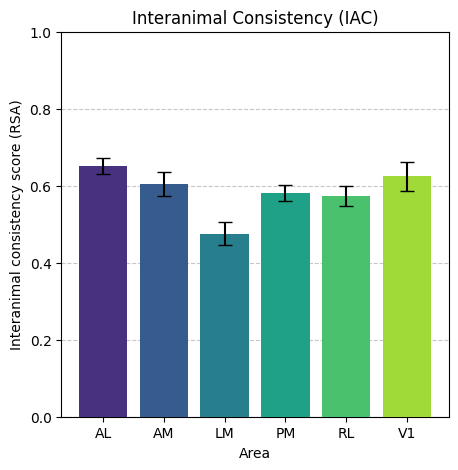

In [3]:
areas = list(iac.keys())
scores = [iac[a] for a in areas]
errors = [iac_sem[a] for a in areas]

# use matplotlib's bar so we can pass yerr directly
x_pos = np.arange(len(areas))
plt.figure(figsize=(5, 5))
plt.grid(True, axis='y', linestyle='--', alpha=0.7, zorder=0)
plt.bar(x_pos, scores, yerr=errors, capsize=5, color=sns.color_palette("viridis", len(areas)), zorder=3)
plt.xticks(x_pos, areas)
plt.xlabel("Area")
plt.ylabel("Interanimal consistency score (RSA)")
plt.ylim(0, 1)
plt.title("Interanimal Consistency (IAC)")
plt.savefig("./image/iac_scores.jpeg", dpi=300, bbox_inches='tight')

# Model neural predictivity

## loading and normalizing by area

In [4]:
def build_model_dfs_from_pickle(pickle_path: str):

    AREA_NORM = {
        "AL": 0.647716,
        "AM": 0.570069,
        "LM": 0.453128,
        "PM": 0.551936,
        "RL": 0.542426,
        "V1": 0.592209,
    }

    # 1) carico
    with open(pickle_path, "rb") as f:
        layer_scores_by_model: dict[str, pd.DataFrame] = pickle.load(f)

    # 2) unico DF lungo
    long = pd.concat(
        [df.assign(model=m) for m, df in layer_scores_by_model.items()],
        ignore_index=True,
    )
    # sanity
    required = {"area", "layer", "score", "model"}
    missing = required - set(long.columns)
    if missing:
        raise ValueError(f"Mancano colonne: {sorted(missing)}")

    # 3) normalizzazione per area (per riga/specimene)
    norm = pd.Series(AREA_NORM, name="norm_factor")
    long = long.merge(norm, left_on="area", right_index=True, how="left")
    if long["norm_factor"].isna().any():
        miss = long.loc[long["norm_factor"].isna(), "area"].unique().tolist()
        raise ValueError(f"Fattore mancante per aree: {miss}")

    long["score"] = long["score"] / long["norm_factor"]

    long = long.drop(columns="norm_factor")

    # 4) aggregazione: mean + SEM dai punteggi normalizzati
    stats_df = (
        long.groupby(["model", "area", "layer"])["score"]
            .agg(mean_score="mean", sem_score=lambda s: s.sem())
            .reset_index()
            .set_index(["model", "area", "layer"])
            .sort_index()
    )

    # 5) dict per plot_comparison
    model_dfs = {
        m: g[["area", "layer", "mean_score", "sem_score"]]
              .rename(columns={"mean_score": "score", "sem_score": "sem"})
              .reset_index(drop=True)
        for m, g in stats_df.reset_index().groupby("model", sort=False)
    }

    return stats_df, model_dfs

# costruisco model_dfs in un colpo
rsa_score_norm_ml_stats, model_dfs = build_model_dfs_from_pickle("rsa_results.pkl")

## Nayebi style

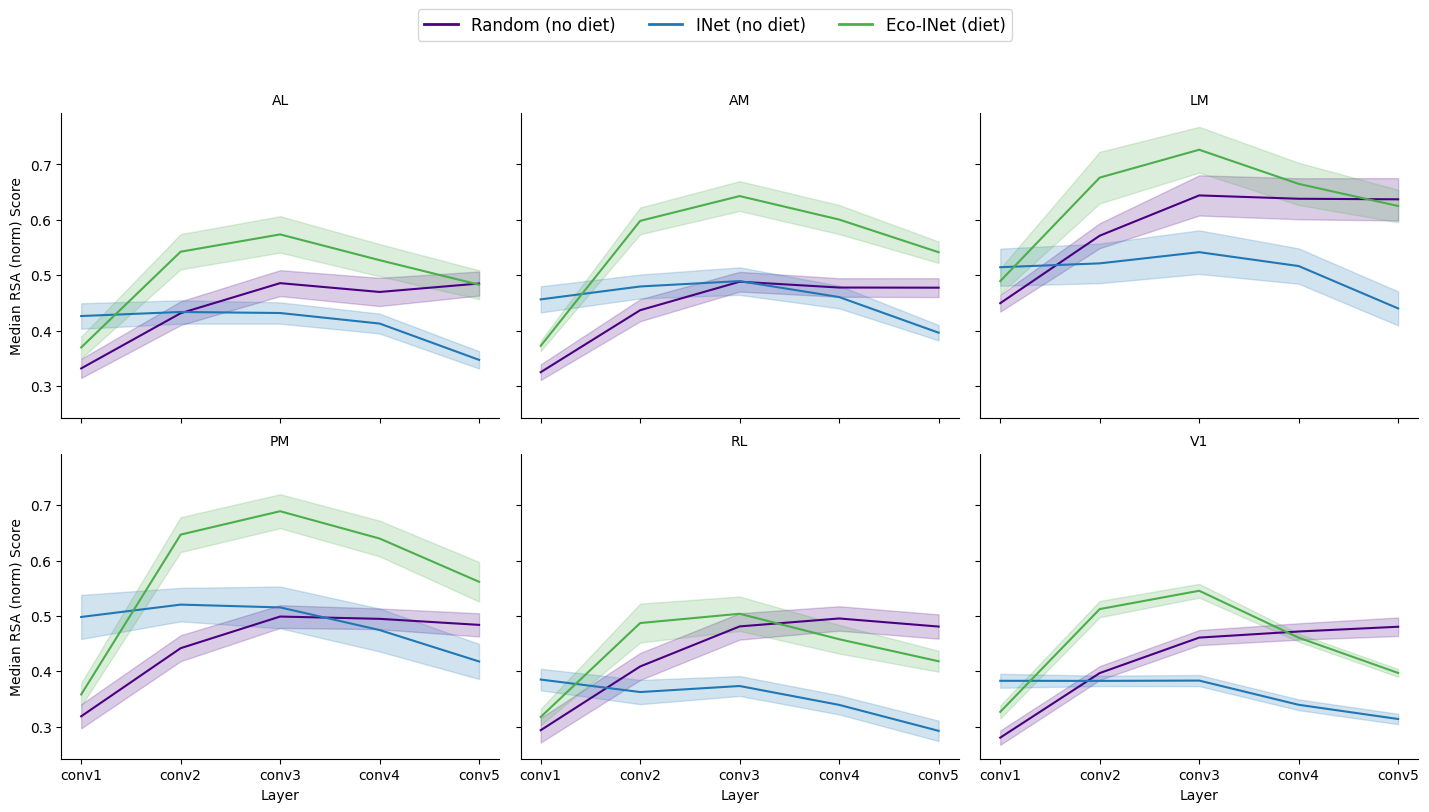

In [5]:
to_plot = {
    "Rand-In"    : model_dfs["Random-no-diet"],
    "INet-In"    : model_dfs["ImageNet-no-diet"],
    "INet-Td-Id" : model_dfs["inet-td-diet"],
}

fig, axes = plot_comparison(to_plot, metric_name="RSA (norm)")
plt.show()

fig.savefig("../report/image/main-result.jpeg", dpi=300, bbox_inches="tight")


## delta

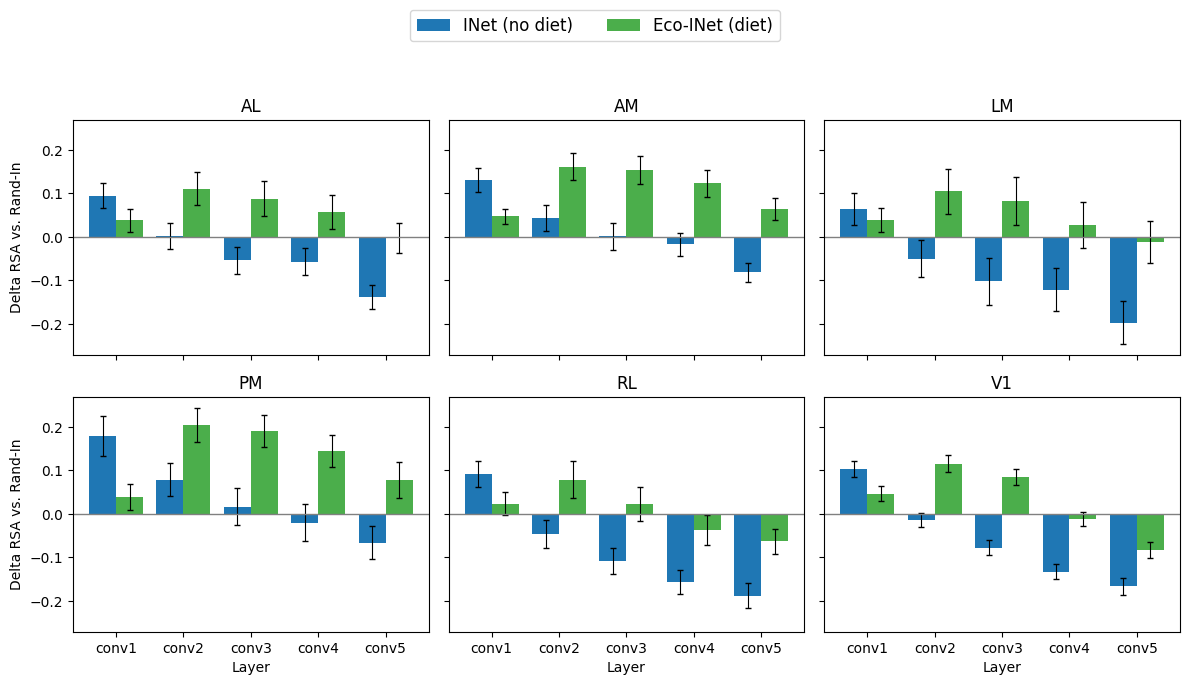

In [6]:
to_plot_rsa = {
    "Rand-In" : model_dfs["Random-no-diet"],
    "INet-In" : model_dfs["ImageNet-no-diet"],
    "INet-Td-Id" : model_dfs["inet-td-diet"],
}

fig, axes = plot_delta_vs_baseline(to_plot_rsa)

plt.show()

fig.savefig("../report/image/deltas.jpeg", dpi=300, bbox_inches="tight")


## inference

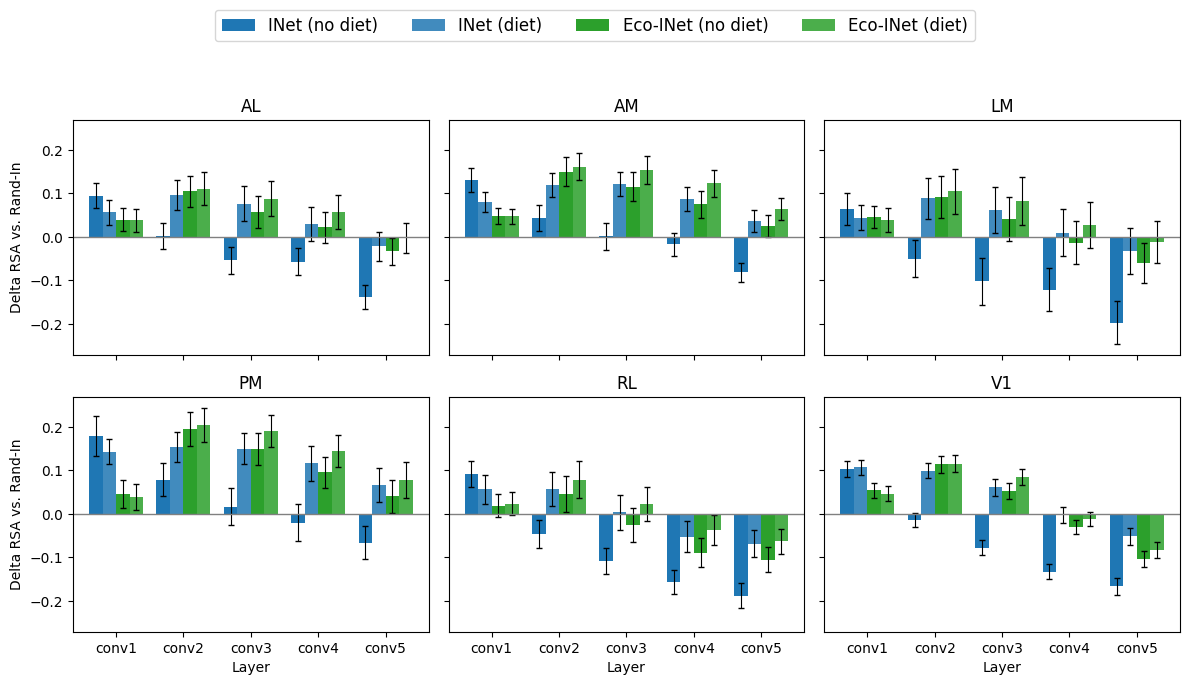

In [7]:
to_plot_rsa = {
    "Rand-In" : model_dfs["Random-no-diet"],
    "INet-In" : model_dfs["ImageNet-no-diet"],
    "INet-Id" : model_dfs["ImageNet-diet"],
    "INet-Td-In" : model_dfs["inet-td-no-diet"],
    "INet-Td-Id" : model_dfs["inet-td-diet"],
}

fig, axes = plot_delta_vs_baseline(to_plot_rsa)

plt.show()

fig.savefig("../report/image/inference.jpeg", dpi=300, bbox_inches="tight")


## Nayebi diet

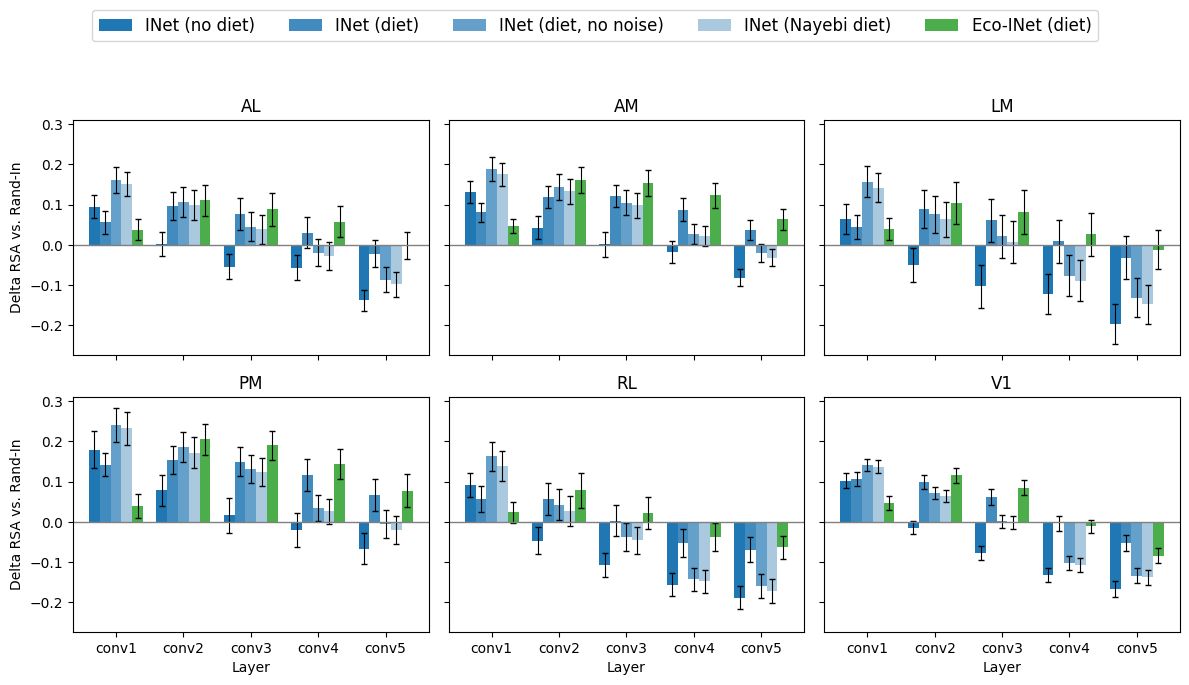

In [8]:
to_plot_rsa = {
    "Rand-In" : model_dfs["Random-no-diet"],
    "INet-In" : model_dfs["ImageNet-no-diet"],
    "INet-Id" : model_dfs["ImageNet-diet"],
    "INet-Idnn" : model_dfs["ImageNet-diet-no-noise"],
    "INet-Iny" : model_dfs["ImageNet-nayebi-diet"],
    "INet-Td-Id" : model_dfs["inet-td-diet"],
}

fig, axes = plot_delta_vs_baseline(to_plot_rsa)

plt.show()

fig.savefig("../report/image/nayebi-diet.jpeg", dpi=300, bbox_inches="tight")


### Comparison (no blur, no noise)

In [9]:
model_dfs.keys()

dict_keys(['ImageNet-diet', 'ImageNet-diet-no-blur', 'ImageNet-diet-no-noise', 'ImageNet-nayebi-diet', 'ImageNet-no-diet', 'ImageNet-random-diet', 'Random-diet', 'Random-diet-no-blur', 'Random-diet-no-noise', 'Random-nayebi-diet', 'Random-no-diet', 'Random-random-diet', 'inet-td-diet', 'inet-td-diet-no-blur', 'inet-td-diet-no-noise', 'inet-td-nayebi-diet', 'inet-td-no-diet', 'inet-td-random-diet'])

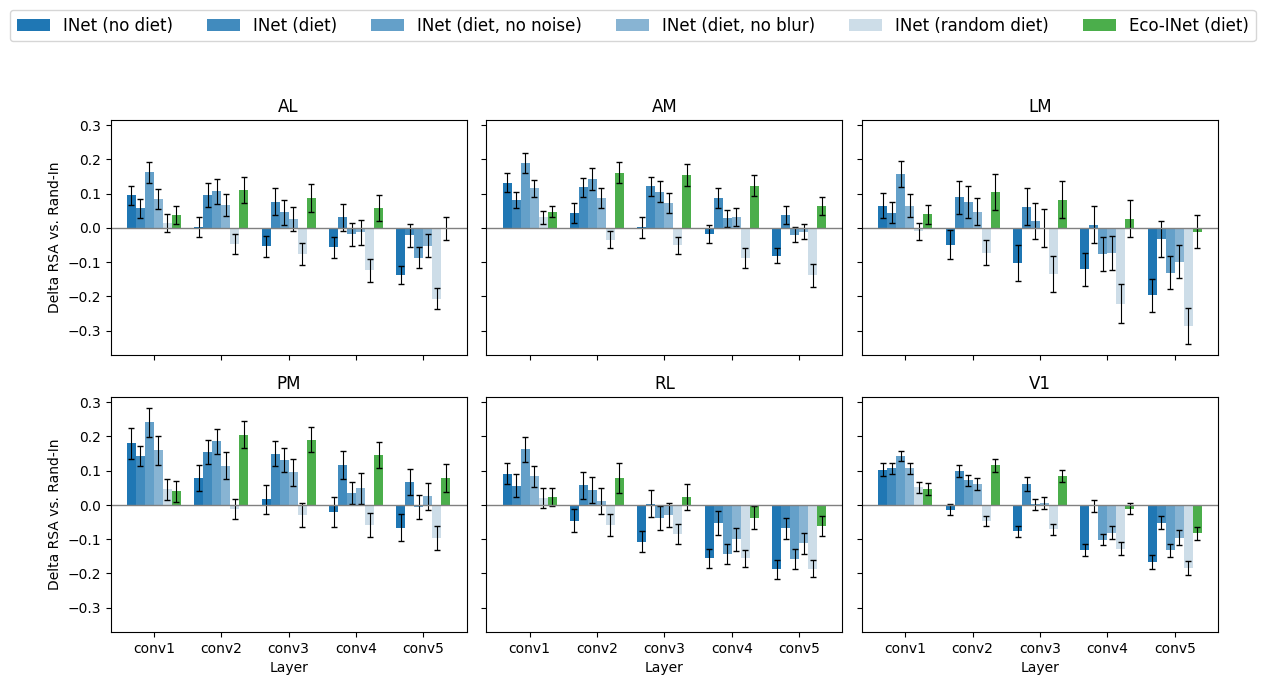

In [10]:
to_plot_rsa = {
    "Rand-In" : model_dfs["Random-no-diet"],
    "INet-In" : model_dfs["ImageNet-no-diet"],
    "INet-Id" : model_dfs["ImageNet-diet"],
    "INet-Idnn" : model_dfs["ImageNet-diet-no-noise"],
    "INet-Idnb" : model_dfs["ImageNet-diet-no-blur"],
    # "INet-Iny" : model_dfs["ImageNet-nayebi-diet"],
    "INet-Ir" : model_dfs["ImageNet-random-diet"],
    "INet-Td-Id" : model_dfs["inet-td-diet"],
}

fig, axes = plot_delta_vs_baseline(to_plot_rsa)

plt.show()

fig.savefig("../report/image/no-noise.jpeg", dpi=300, bbox_inches="tight")


perchè il noise è problematico per la neural similarity in conv1?

\begin{equation}
    x' = x + \eta
\end{equation}

\begin{equation}    
    z^1(x) = \text{ReLU}(W*x+b)
\end{equation}

\begin{equation}    
    z^1(x') = \text{ReLU}(W*(x + \eta)+b) \approx z^1(x) + W*\eta
\end{equation}

\begin{equation}    
    \text{RDM}^{(1)}_{i,j} = 1 - \text{Corr}(z^1(x'_i),  z^1(x'_j))
\end{equation}

e aumentando il rumore $\eta$, diminuisce la correlazione tra i segnali (lineare nel rumore) (see random diet).

## random

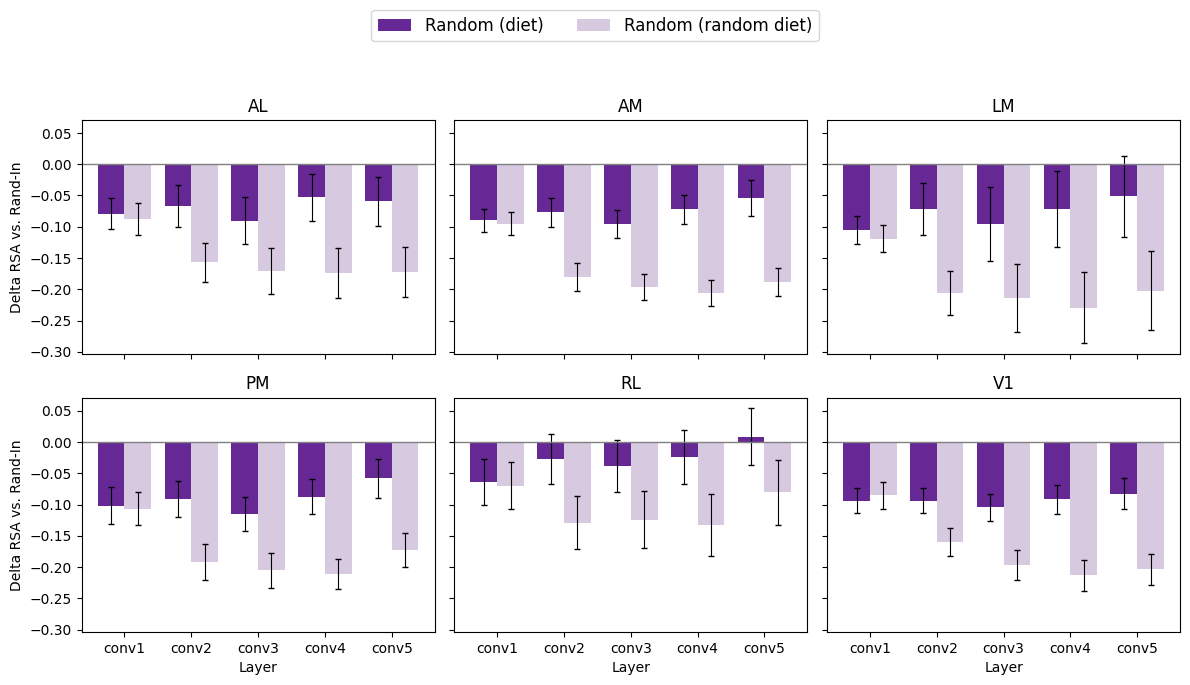

In [12]:
to_plot = {
    "Rand-In" : model_dfs["Random-no-diet"],
    "Rand-Id" : model_dfs["Random-diet"],
    # "Rand-Idnn" : model_dfs["Random-diet-no-noise"],
    # "Rand-Idnb" : model_dfs["Random-diet-no-blur"],
    # "Rand-Iny" : model_dfs["Random-nayebi-diet"],
    "Rand-Ir" : model_dfs["Random-random-diet"],
}

fig, axes = plot_delta_vs_baseline(to_plot)
plt.show()
fig.savefig("../report/image/random.jpeg", dpi=300, bbox_inches="tight")